# Tender Classification by its Title

The following data contains 160k tenders from different countries in Europe.

As our goal is to categorise them based on the text found in the tender, we will just focus on title and description.

The label attribute is a binary representation of the attributes "General", "Defence","Education & Culture","Energy & Environment","Health & Care","Infrastructure & Construction","Professional Services","Technology & Communications","Transport & Logistics”.

First step: make sure transformers are installed for BERT

In [ ]:
pip install transformers

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
import keras 
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout, LSTM, RNN, BatchNormalization

import tensorflow_hub as hub

from transformers import BertTokenizer

import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Advanced ML/contracts-train.csv')

In [5]:
data.head()

,docid,publication_date,contract_type,nature_of_contract,country_code,country_name,sector,value,title,description,awarding_authority,complete_entry,General,Defence,Education & Culture,Energy & Environment,Health & Care,Infrastructure & Construction,Professional Services,Technology & Communications,Transport & Logistics,label
0,2265917679,2020-04-02,notice,services,FR,France,public,NaN,France-Nantes: Evaluation consultancy services,La présente consultation porte sur la mission ...,Nantes Métropole,<b>Type of document:</b> Additional informatio...,False,False,False,False,False,False,True,False,False,100
1,2216312773,2020-02-21,award,supplies,DE,Germany,public,1.0,Germany-Hamburg: Network components,Die TK plant die Beschaffung von Intrusion Pre...,Techniker Krankenkasse,<b>Type of document:</b> Contract Awards\n<b>C...,True,False,False,False,False,False,True,True,False,100000110
2,2272239011,2020-04-08,award,works,DE,Germany,public,1349412.0,Germany-Düsseldorf: Works for complete or part...,"— Technisches Gebäudemanagement (TGM), BLB NRW...",Bau- und Liegenschaftsbetrieb NRW Zentrale,<b>Type of document:</b> Contract Awards\n<b>C...,True,False,False,False,False,True,False,False,False,100001000
3,2223768560,2020-02-27,notice,supplies,GB,United Kingdom,public,5000000.0,United Kingdom-London: Gas Materials (Inc Boil...,The Hyde Group (THG) is looking to enter into ...,Hyde Housing Association (The Hyde Group),<b>Type of document:</b> Invitation to tender\...,False,False,False,False,False,True,False,False,False,1000
4,2211260904,2020-02-18,notice,services,NO,Norway,public,NaN,"Norway-Oslo: IT services: consulting, software...",The Agency for Planning and Building Services ...,Oslo kommune v/Plan- og bygningsetaten,<b>Type of document:</b> Pre-information proce...,False,False,False,False,False,False,True,False,False,100


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   docid                          160000 non-null  int64  
 1   publication_date               160000 non-null  object 
 2   contract_type                  160000 non-null  object 
 3   nature_of_contract             159985 non-null  object 
 4   country_code                   159999 non-null  object 
 5   country_name                   160000 non-null  object 
 6   sector                         160000 non-null  object 
 7   value                          84856 non-null   float64
 8   title                          160000 non-null  object 
 9   description                    160000 non-null  object 
 10  awarding_authority             160000 non-null  object 
 11  complete_entry                 160000 non-null  object 
 12  General                       

In [7]:
data.isna().sum()

docid                                0
publication_date                     0
contract_type                        0
nature_of_contract                  15
country_code                         1
country_name                         0
sector                               0
value                            75144
title                                0
description                          0
awarding_authority                   0
complete_entry                       0
General                              0
Defence                              0
Education & Culture                  0
Energy & Environment                 0
Health & Care                        0
Infrastructure & Construction        0
Professional Services                0
Technology & Communications          0
Transport & Logistics                0
label                                0
dtype: int64

We can observe there are a few Na's in our data, but as we will be focusing just in the title and description, this should be no problem as these two categories are complete.

In [8]:
X = data[['title','description']]
target = data[["General", "Defence","Education & Culture","Energy & Environment",
               "Health & Care","Infrastructure & Construction","Professional Services",
               "Technology & Communications","Transport & Logistics"]].astype(int)

Lets observe how the tenders are classified.

In [75]:
target.head()

,General,Defence,Education & Culture,Energy & Environment,Health & Care,Infrastructure & Construction,Professional Services,Technology & Communications,Transport & Logistics
0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,1,1,0
2,1,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0


There are 9 categories and a tender can belong to more than one of these cateogires

We will try out 2 different methods:
    
    1. Recurrent Neural Networks (RNNs)
    
    2. BERT
    
For RNNs we will use embedding layers, where we will need to clean our text (i.e. remove stopwords, special symbols, punctuation, stemming, lowercasing all words)

In [9]:
data['country_name'].value_counts()

Germany           30412
France            22995
Poland            19244
Spain             10143
United Kingdom     8274
                  ...  
Chad                  1
Jordan                1
Afghanistan           1
Fiji                  1
Malaysia              1
Name: country_name, Length: 105, dtype: int64

We have tenders from 105 different countries.  We can observe from the data head that all titles are in english, however, descriptions are in the country's native language.

This can cause us some trouble if we want to analyse the discription too.  Using RNNs, the way to go would be to translate all descriptions to the same language as we want our embeddings to have the same value for every word with the same meaning disregarding the language.  Sadly Google translate free API doesnt allow for more than 15000 characters a day so we wont be able to do this.

For BERT, as it uses its own dictionary, a function that detects the language and tokenizes the sentence with the correct dictionary can be used.


For this project we will just evaluate the title, let's have a peek of the title:

In [80]:
data['title'][:15]

0        France-Nantes: Evaluation consultancy services
1                   Germany-Hamburg: Network components
2     Germany-Düsseldorf: Works for complete or part...
3     United Kingdom-London: Gas Materials (Inc Boil...
4     Norway-Oslo: IT services: consulting, software...
5     United Kingdom-Stirling: Roads Maintenance and...
6     Belgium-Namur: Electrical machinery, apparatus...
7     France-Wallers-Arenberg: Building-cleaning ser...
8     France-Créteil: Architectural, construction, e...
9               Portugal-Lisbon: Sewage treatment works
10                                  Spain-Madrid: Tools
11    Denmark-Ballerup: Repair and maintenance services
12    United Kingdom-London: BTA1189 — Microgapping ...
13                  Germany-Hanau: Engineering services
14     Germany-Düsseldorf: Flash memory storage devices
Name: title, dtype: object

As a first step, we'll split the title column, as it contains the country, the city and finally the real title

In [10]:
X['title2'] = 0
for i in range(len(X['title'])):
    title_split = X['title'][i].split("-",1)[1].split(':')
    X['title2'][i] = title_split[1]

Next we define a function to remove stopwords, special symbols, punctuation, stemming and lowercase all words

In [11]:
#TO DOWNLOAD STOPWORDS, PUNCTUATION, SYMBOLS, ETC
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    
    return " ".join(filtered_words).split()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [12]:
X['clean_title'] = X['title2'].map(lambda s:preprocess(s))
X.drop(['title','description'], axis=1, inplace=True)

In [13]:
X.head()

,title2,clean_title
0,Evaluation consultancy services,"[evaluation, consultancy, services]"
1,Network components,"[network, components]"
2,Works for complete or part construction and c...,"[works, complete, part, construction, civil, e..."
3,Gas Materials (Inc Boilers and Associated Plu...,"[gas, materials, inc, boilers, associated, plu..."
4,IT services,[services]


Title2 will be kept for BERT, as it encodes the complete sentence its way with its dictionary.

# Data Preprocessing for RNN

For the embeddings for our RNN we will use clean_title.

Also, we will fit the Keras tokenizer on our whole data to get the biggest dictionary possible.

In [36]:
title_tokenizer = Tokenizer()
title_tokenizer.fit_on_texts(X['clean_title'])

In [ ]:
title_tokenizer.get_config()['word_index']

#Title vocab length: 10249

In [38]:
longest_title = X.clean_title.map(len).max()
longest_title

35

We also see that the longest title is 35 characters

# Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, random_state=42)

In [39]:
#Embedding train title
train_tokens_title = title_tokenizer.texts_to_sequences(X_train['clean_title'])
padded_train_title = pad_sequences(train_tokens_title, maxlen = longest_title, padding = 'post') #Title input

# Building the RNN

First, we will define a function for learning rate smoothing, this will tune the learning rate to smaller values the lower the error

In [43]:
def exponential_decay(lr0,s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.001, s=20)

lr_schedular = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [44]:
title_inputs = tf.keras.layers.Input((longest_title,), dtype='int32', name='title_inputs')


lstm_layer_title = tf.keras.layers.LSTM(128)
embedding_layer_title = tf.keras.layers.Embedding(10250, 200, input_length=longest_title)

title = embedding_layer_title(title_inputs)
title = tf.keras.layers.LSTM(256, return_sequences=True, input_shape=(None, 35, 1))(title)
title = tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(None, 35, 1))(title)
title = tf.keras.layers.LSTM(128)(title)
title = tf.keras.layers.Dense(2000, activation='relu', kernel_initializer='GlorotNormal')(title)
title = tf.keras.layers.Dense(1000, activation='relu', kernel_initializer='GlorotNormal')(title)
title = tf.keras.layers.Dropout(0.2)(title)

out = tf.keras.layers.Dense(9, activation='sigmoid', name='output')(title)

In [45]:
RNN_model = tf.keras.models.Model(inputs = [title_inputs], 
                              outputs = out)
print(RNN_model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
title_inputs (InputLayer)    [(None, 35)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 35, 200)           2050000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 35, 256)           467968    
_________________________________________________________________
lstm_2 (LSTM)                (None, 35, 128)           197120    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 2000)              258000    
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2001

In [46]:
RNN_model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=["accuracy"])

history_RNN = RNN_model.fit(padded_train_title, 
                    y_train.values, 
                    epochs = 10, 
                    validation_split=0.2, 
                    batch_size=100)

Epoch 1/10
896/896 [==============================] - 41s 27ms/step - loss: 0.3483 - accuracy: 0.3371 - val_loss: 0.1608 - val_accuracy: 0.7877
Epoch 2/10
896/896 [==============================] - 25s 27ms/step - loss: 0.1456 - accuracy: 0.8271 - val_loss: 0.1174 - val_accuracy: 0.8692
Epoch 3/10
896/896 [==============================] - 25s 27ms/step - loss: 0.1107 - accuracy: 0.8805 - val_loss: 0.1123 - val_accuracy: 0.8766
Epoch 4/10
896/896 [==============================] - 25s 27ms/step - loss: 0.0996 - accuracy: 0.8959 - val_loss: 0.1021 - val_accuracy: 0.8918
Epoch 5/10
896/896 [==============================] - 24s 27ms/step - loss: 0.0917 - accuracy: 0.9060 - val_loss: 0.1004 - val_accuracy: 0.8970
Epoch 6/10
896/896 [==============================] - 25s 27ms/step - loss: 0.0877 - accuracy: 0.9107 - val_loss: 0.0975 - val_accuracy: 0.8975
Epoch 7/10
896/896 [==============================] - 25s 28ms/step - loss: 0.0845 - accuracy: 0.9146 - val_loss: 0.0991 - val_accuracy:

<function matplotlib.pyplot.show>

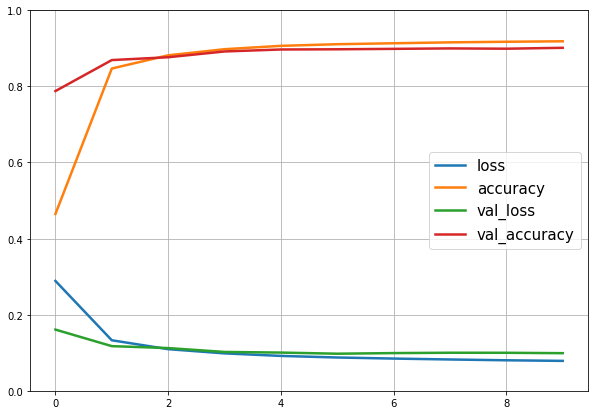

In [47]:
pd.DataFrame(history_RNN.history).plot(figsize=(10,7), linewidth = 2.5)
plt.grid(True)
plt.legend(fontsize=15)
plt.gca().set_ylim(0,1)
plt.show

#Test

In [48]:
#Embedding train title
test_tokens_title = title_tokenizer.texts_to_sequences(X_test['clean_title'])
padded_test_title = pad_sequences(test_tokens_title, maxlen = longest_title, padding = 'post') #Title input

In [50]:
predictions_RNN = RNN_model.predict((padded_test_title))

results_RNN = []
for row in range(len(predictions_RNN)):
  row_list = []
  for value in predictions_RNN[row]:
    if value >= 0.5:
      row_list.append(1)
    else:
      row_list.append(0)
  results_RNN.append(row_list)

In [51]:
loss, accuracy = RNN_model.evaluate(padded_test_title, y_test.values)
print('Using title data with a simple RNN, the F1 score on the validation set is', accuracy)

1500/1500 [==============================] - 11s 6ms/step - loss: 0.0977 - accuracy: 0.9038
Using title data with a simple RNN, the F1 score on the validation set is 0.9037708044052124


In [52]:
print('Just title with a simple RNN, F1 Score: ', f1_score(y_test.values, results_RNN, average='macro'))

Just title with a simple RNN, F1 Score:  0.8467662099027317


With just title and a RNN, we can predict the tender accuracy with an accuracy of 90% and an F1 score of 84% which dont seem bad.

#BERT

As bert uses its own dictionary and tokenizer, we import the trained tokenizer for bert

In [15]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

We import our pretrained bert layer

In [16]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2, Total size: 683.05MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2'.


BERT likes its input with a special encoding/tokenization, for that we will use a function to turn the sentences into something BERT can accept

In [17]:
#First we define the length of the longest title (This will be different than the previous model as bert takes the full sentence with stopwords, etc)
max_seq_length = X['title2'].str.len().max()

def encode_names(n, tokenizer):
    tokens = list(tokenizer.tokenize(n))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
    num_examples = len(string_list)
  
    string_tokens = tf.ragged.constant([encode_names(n, tokenizer) for n in np.array(string_list)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
    input_word_ids = tf.concat([cls, string_tokens], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

    type_cls = tf.zeros_like(cls)
    type_tokens = tf.ones_like(string_tokens)
    input_type_ids = tf.concat([type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [30]:
title_train_BERT = bert_encode(X_train['title2'], tokenizer, max_seq_length)
title_test_BERT = bert_encode(X_test['title2'], tokenizer, max_seq_length)

In [23]:
max_seq_length = max_seq_length

##Title inputs
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")


#Title
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])  
output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)

#title = tf.keras.layers.Dense(2000, activation='relu', kernel_initializer='GlorotNormal')(title)

output = tf.keras.layers.Dense(9, activation='sigmoid', name='output')(output)


BERT_model = tf.keras.Model(inputs=[{'input_word_ids': input_word_ids,
                                'input_mask': input_mask,
                                'input_type_ids': segment_ids}], 
                       outputs=output)

In [24]:
print(BERT_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 334)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 334)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 334)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

Although the authors state that datasets with >100k samples are less sensible to hyperparameter tuning (we have 112k samples), we fit BERT with the author's recommendations:

Learning rate = 5e-5, 3e-5 or 2e-5

Batch size = 16 or 32

epochs = 3 or 4



In [27]:
BERT_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 2e-5), loss='binary_crossentropy', metrics=['accuracy'])

history_BERT = BERT_model.fit(title_train_BERT, 
                    y_train.values, 
                    epochs = 3, 
                    validation_split = 0.2, 
                    batch_size = 16)

Epoch 1/3
5600/5600 [==============================] - 2386s 425ms/step - loss: 0.0810 - accuracy: 0.9137 - val_loss: 0.0938 - val_accuracy: 0.9010
Epoch 2/3
5600/5600 [==============================] - 2380s 425ms/step - loss: 0.0771 - accuracy: 0.9190 - val_loss: 0.0917 - val_accuracy: 0.9049
Epoch 3/3
5600/5600 [==============================] - 2381s 425ms/step - loss: 0.0743 - accuracy: 0.9203 - val_loss: 0.0942 - val_accuracy: 0.9057


In [33]:
predictions_BERT = BERT_model.predict((title_test_BERT))

results_BERT = []
for row in range(len(predictions_BERT)):
  row_list = []
  for value in predictions_BERT[row]:
    if value >= 0.5:
      row_list.append(1)
    else:
      row_list.append(0)
  results_BERT.append(row_list)

In [34]:
loss, accuracy = BERT_model.evaluate(title_test_BERT, y_test.values)
print('Using title data with BERT, the F1 score on the validation set is', accuracy)

1500/1500 [==============================] - 372s 248ms/step - loss: 0.0939 - accuracy: 0.9072
Using title data with BERT, the F1 score on the validation set is 0.9072083234786987


In [35]:
print('Just title with BERT, F1 Score: ', f1_score(y_test.values, results_BERT, average='macro'))

Just title with BERT, F1 Score:  0.8534984143234196


With just title and a BERT, we can predict the tender accuracy with an accuracy of 90% and an F1 score of 85% which dont seem bad.

With our current dataset and objective, we have obtained almost similar results with both methods, with BERT scoring just 1% better on its F1 score.

In this case it seems the extra training time for BERT (30 minutes per epoch) dont seem worth it.

#Testing on new sentences

In [73]:
#We create a small function to directly tokenize sentences for the RNN
def tokenize_sentence(sentence):
  tokenized_sentence = title_tokenizer.texts_to_sequences(sentence)
  padded_sentence = pad_sequences(tokenized_sentence, maxlen = longest_title, padding = 'post')
  return(padded_sentence)

#Defining our categories to map them later
categories = ["General", "Defence","Education & Culture","Energy & Environment","Health & Care","Infrastructure & Construction","Professional Services","Technology & Communications","Transport & Logistics"]

In [71]:
#Edit new_sentence to try new 'titles'
new_sentence = 'Concrete and General Repair Works to the East Side Salt Barn'

#RNN
processed_sentence_RNN = ' '.join(preprocess(new_sentence))
sentece_ready_RNN = tokenize_sentence([processed_sentence_RNN])
sentence_prediction_RNN = RNN_model.predict(sentece_ready_RNN)
sentence_result_RNN = np.where(sentence_prediction_RNN > 0.5, 1, 0).tolist()
category_index_RNN = [i for i,val in enumerate(sentence_result_RNN[0]) if val==1]

#BERT
processed_sentence_BERT = ' '.join(preprocess(new_sentence))
sentece_ready_BERT = bert_encode([processed_sentence_BERT], tokenizer, max_seq_length)
sentence_prediction_BERT = BERT_model.predict(sentece_ready_BERT)
sentence_result_BERT = np.where(sentence_prediction_BERT > 0.5, 1, 0).tolist()
category_index_BERT = [i for i,val in enumerate(sentence_result_BERT[0]) if val==1]

In [72]:
print('According the RNN, the input sentence:')
print('-', new_sentence, '-')
print('the tender corresponds to: ')
print('\n')
for i in category_index_RNN:
  print(categories[i])

print('\n')

print('According the BERT, the input sentence:')
print('-', new_sentence, '-')
print('the tender corresponds to: ')
print('\n')
for i in category_index_BERT:
  print(categories[i])

According the RNN, the input sentence:
- Concrete and General Repair Works to the East Side Salt Barn -
the tender corresponds to: 


Infrastructure & Construction


According the BERT, the input sentence:
- Concrete and General Repair Works to the East Side Salt Barn -
the tender corresponds to: 


Infrastructure & Construction
